In [1]:
from scipy import io
from scipy.signal import butter, lfilter
from scipy import signal

import h5py
import random
import numpy as np
import os

import datetime
from time import gmtime, strftime, time

from nd_legacy import *

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from bot_slacker import send_slack_message, send_slack_picture
send_slack_message("test (startup)")

### Load data

In [4]:
ecog_matfile = io.loadmat('test_ecog_data.mat')
raw_data = ecog_matfile['raw_data']
raw_acc = ecog_matfile['raw_acc']
mv_acc = ecog_matfile['mv_acc']

sampling_rate = 2000

raw_data = raw_data[:,0:-10000]
raw_acc = raw_acc[:,0:-10000]
mv_acc = mv_acc[:,0:-10000]

print(raw_data.shape)
print(raw_acc.shape)
print(mv_acc.shape)

len_raw_data = raw_data.shape[1]
print(len_raw_data)

(12, 126001)
(1, 126001)
(1, 126001)
126001


In [5]:
chan_names = ecog_matfile['chan_names']

chan_names = chan_names[0]
chan_names = chan_names.tolist()
for i in range(len(chan_names)):
  chan_names[i] = chan_names[i][0]

print(chan_names)

[u'P3_1_d', u'P3_2_d', u'F3_1_d', u'F3_2_d', u'C3_1_d', u'C3_2_d', u'C3_3_d', u'C3_4_d', u'T5_1_d', u'T5_2_d', u'T5_3_d', u'T5_4_d']


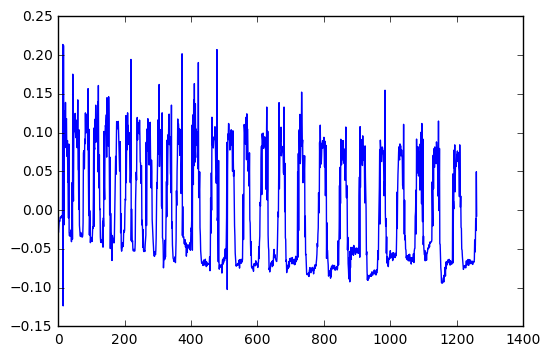

In [6]:
plt.plot(raw_acc[0,::100])

(1, 126001)


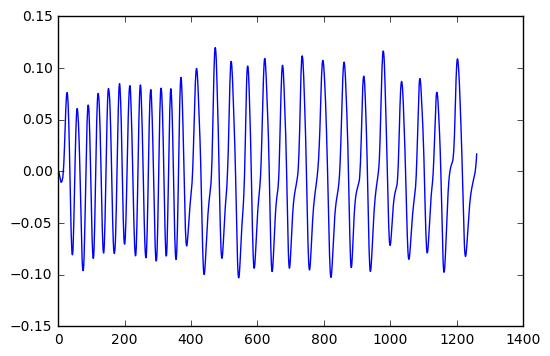

In [7]:
raw_acc_f = butter_bandpass_filter(raw_acc, 0.1, 1, sampling_rate, order=3, how_to_filt = 'separately')
print(raw_acc_f.shape)
plt.plot(raw_acc_f[0,::100])

### Convert to spectrogram

In [8]:
srate = 2000
nperseg=1000
noverlap = 999
step = nperseg - noverlap

In [9]:
f, t, raw_data_spec_1 = signal.spectrogram(raw_data[4:8,:].T, fs=srate, nperseg=nperseg, noverlap=noverlap, axis = 0, mode="magnitude")
f, t, raw_data_spec_2 = signal.spectrogram(raw_data[4:8,:].T, fs=srate, nperseg=nperseg, noverlap=noverlap, axis = 0, mode="angle")

In [10]:
print(raw_data_spec_1.shape)
print(raw_data_spec_2.shape)

(501, 4, 125002)
(501, 4, 125002)


In [11]:
raw_data_spec = np.concatenate((raw_data_spec_1,raw_data_spec_2),axis=1)
print(raw_data_spec.shape)

(501, 8, 125002)


In [12]:
raw_data_spec = abs(raw_data_spec)
raw_data_spec = np.swapaxes(raw_data_spec,1,2)
raw_data_spec = raw_data_spec[:50,:,:]
f = f[:50]

In [13]:
raw_acc_f_spec = raw_acc_f[:,noverlap:]
#raw_acc_f_spec = raw_acc_f[:,noverlap:-1:step]
raw_acc_f_spec.shape

(1, 125002)

In [14]:
raw_data_spec.shape

(50, 125002, 8)

In [15]:
f

array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
        22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
        44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,
        66.,  68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,
        88.,  90.,  92.,  94.,  96.,  98.])

In [16]:
t

array([  0.25  ,   0.2505,   0.251 , ...,  62.7495,  62.75  ,  62.7505])

In [17]:
len_raw_data_spec = raw_data_spec.shape[1]
len_raw_data_spec

125002

In [18]:
raw_data_train = raw_data[4:8,0:(len_raw_data//2)]
raw_data_val = raw_data[4:8,(len_raw_data//2):(2*len_raw_data//3)]
raw_data_test = raw_data[4:8,(2*len_raw_data//3):(-1000)]

#mv_acc_train = mv_acc[:,0:(len_raw_data//2)]
#mv_acc_val = mv_acc[:,(len_raw_data//2):(2*len_raw_data//3)]
#mv_acc_test = mv_acc[:,(2*len_raw_data//3):]

mv_acc_train = raw_acc_f[:,0:(len_raw_data//2)]
mv_acc_val = raw_acc_f[:,(len_raw_data//2):(2*len_raw_data//3)]
mv_acc_test = raw_acc_f[:,(2*len_raw_data//3):(-1000)]

raw_data_train_spec = raw_data_spec[:,0:(len_raw_data_spec//2)]
raw_data_val_spec = raw_data_spec[:,(len_raw_data_spec//2):(2*len_raw_data_spec//3)]
raw_data_test_spec = raw_data_spec[:,(2*len_raw_data_spec//3):(-1000)]

mv_acc_train_spec = raw_acc_f_spec[:,0:(len_raw_data_spec//2)]
mv_acc_val_spec = raw_acc_f_spec[:,(len_raw_data_spec//2):(2*len_raw_data_spec//3)]
mv_acc_test_spec = raw_acc_f_spec[:,(2*len_raw_data_spec//3):(-1000)]

#### check dimensions

In [19]:
print(mv_acc_train_spec.shape)
print(raw_data_train_spec.shape)
print("\n")
print(raw_data_val_spec.shape)
print(mv_acc_val_spec.shape)
print("\n")
print(raw_data_test_spec.shape)
print(mv_acc_test_spec.shape)
print("\n")
print(raw_data_spec.shape)
print(raw_acc_f_spec.shape)

(1, 62501)
(50, 62501, 8)


(50, 20833, 8)
(1, 20833)


(50, 40668, 8)
(1, 40668)


(50, 125002, 8)
(1, 125002)


In [20]:
print(raw_data_train.shape)
print(mv_acc_train.shape)

print(raw_data_val.shape)
print(mv_acc_val.shape)

print(raw_data_test.shape)
print(mv_acc_test.shape)

(4, 63000)
(1, 63000)
(4, 21000)
(1, 21000)
(4, 41001)
(1, 41001)


In [21]:
#plt.plot(8*raw_acc_f[0,::10],'b',mv_acc[0,::10],'g')

### Functions for data generation (to fit with fit_generator)

In [22]:
def generate_slice_fromspec(slice_len, val=False, test=False):
    if val:
        X = raw_data_val_spec
        y = mv_acc_val_spec
    elif ~test:
        X = raw_data_train_spec
        y = mv_acc_train_spec
    else:
        X = raw_data_test_spec
        y = mv_acc_test_spec
    
    len_X = X.shape[1]
    
    while True:
        slice_start = np.random.choice(len_X - slice_len)
        slice_end = slice_start + slice_len
        slice_x = X[:,slice_start:slice_end,:]
        slice_y = y[0,slice_end]
            
        return slice_x, slice_y

In [23]:
testx.shape

NameError: name 'testx' is not defined

In [24]:
def generate_slice(slice_len, val=False, spec=False, test=False):
    if val:
        X = raw_data_val
        y = mv_acc_val
    elif ~test:
        X = raw_data_train
        y = mv_acc_train
    else:
        X = raw_data_test
        y = mv_acc_test
    
    len_X = X.shape[1]
    
    while True:
        slice_start = np.random.choice(len_X - slice_len)
        slice_end = slice_start + slice_len
        slice_x_raw = X[:,slice_start:slice_end].T
        slice_y = y[0,slice_end]
        
        if(spec):
            f, t, slice_x = signal.spectrogram(slice_x_raw, fs=srate, nperseg=nperseg, noverlap=noverlap, axis = 0, mode="complex")
            slice_x = abs(slice_x)
            slice_x = np.swapaxes(slice_x,1,2)
            slice_x = slice_x[:50,:,:]
            f = f[:50]
        else:
            slice_x = slice_x_raw
            f = None
            t = None
            
        return slice_x, slice_y, f, t

In [25]:
def data_generator(batch_size, slice_len, val=False, spec=False):
    while True:
        batch_x = []
        batch_y = []
        
        for i in range(0, batch_size):
            #x, y, f, t = generate_slice(slice_len, val=val, spec=spec)
            x, y = generate_slice_fromspec(slice_len, val=val)
            batch_x.append(x)
            batch_y.append(y)
            
        y = np.array(batch_y)
        x = np.array([i for i in batch_x])
        yield (x, y)

### Training neural network

In [26]:
from keras.layers import Conv2D, Dense, Dropout, Input, merge, GlobalMaxPooling1D, GlobalMaxPooling2D, MaxPooling1D, MaxPooling2D, Flatten, LSTM, BatchNormalization
from keras.models import Model, load_model
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


#### Params

In [27]:
slice_len = 2000
slice_len_spec = slice_len//step

nb_filters = 5
kernel_size = 3

dense1_n = 100
do = 0

path_to_save_model = 'testmodel2'

#### Set input size

In [28]:
testx, testy, testf, testt = generate_slice(slice_len, val=True, spec = True)
input_size = testx.shape
input_size

(50, 1001, 4)

In [29]:
testx, testy = generate_slice_fromspec(slice_len_spec)
input_size = testx.shape
input_size

(50, 2000, 8)

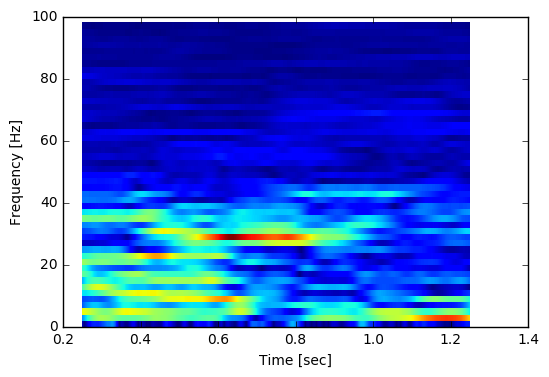

In [30]:
plt.pcolormesh(t[0:slice_len_spec], f, testx[:,:,0])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

#### Architecture

In [211]:
input_seq = Input(shape=input_size)

bn = BatchNormalization(axis = -1)(input_seq)

convolved = Conv2D(nb_filters, kernel_size=[3,5], padding="same", activation="elu")(bn)
convolvedbn = BatchNormalization(axis = -1)(convolved)
pooled = MaxPooling2D(pool_size = [2, 4])(convolvedbn)

convolved2 = Conv2D(nb_filters*4, kernel_size=[3,5], padding="same", activation="elu")(pooled)
convolved2bn = BatchNormalization(axis = -1)(convolved2)
pooled2 = MaxPooling2D(pool_size = [2, 4])(convolved2bn)

convolved3 = Conv2D(nb_filters*4*4, kernel_size=[3,3], padding="same", activation="elu")(pooled2)
convolved3bn = BatchNormalization(axis = -1)(convolved3)
pooled3 = MaxPooling2D(pool_size = [2, 4])(convolved3bn)

convolved4 = Conv2D(nb_filters*4*4*4, kernel_size=[3,3], padding="same", activation="elu")(pooled3)
convolved4bn = BatchNormalization(axis = -1)(convolved4)
pooled4 = MaxPooling2D(pool_size = [2, 4])(convolved4bn)

convolved5 = Conv2D(nb_filters*4*4*2*4, kernel_size=[3,3], padding="same", activation="elu")(pooled4)
convolved5bn = BatchNormalization(axis = -1)(convolved5)
pooled5 = GlobalMaxPooling2D()(convolved5bn)

#flat = Flatten()(pooled4)

dense1 = Dense(500, activation="elu", kernel_initializer="glorot_normal")(pooled5)
dense1bn = BatchNormalization(axis = -1)(dense1)
dense1do = Dropout(0.2)(dense1bn)

#dense2 = Dense(dense2_n, activation="relu")(dense1do)
#dense2bn = BatchNormalization()(dense2)
#dense2do = Dropout(do)(dense2bn)

out = Dense(1, activation='linear')(dense1do)

model = Model(inputs=input_seq, outputs=out)

model.compile(loss="mse", optimizer="adam", metrics=["mse"])

model.summary()

#nb_epoch = 100000


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 50, 2000, 8)       0         
_________________________________________________________________
batch_normalization_122 (Bat (None, 50, 2000, 8)       32        
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 50, 2000, 5)       605       
_________________________________________________________________
batch_normalization_123 (Bat (None, 50, 2000, 5)       20        
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 25, 500, 5)        0         
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 25, 500, 20)       1520      
_________________________________________________________________
batch_normalization_124 (Bat (None, 25, 500, 20)       80        
__________

#### Early stopping

In [212]:
nb_samples = 300
nb_val_samples = 100
nb_epochs = 200
patience = 20

batch_size = 32

earlyStopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(path_to_save_model, monitor='val_loss', verbose=1,
                               save_best_only=True, mode='auto', period=1)

#### Fit

In [ ]:
history = model.fit_generator(data_generator(slice_len=slice_len_spec, batch_size=batch_size, val=False, spec=True), 
                    steps_per_epoch=nb_samples, 
                    epochs = nb_epochs, 
                    callbacks=[earlyStopping, checkpointer], verbose=1, validation_steps=nb_val_samples, 
                    validation_data=data_generator(slice_len=slice_len_spec, batch_size=batch_size, val=True, spec=True))

Epoch 1/200
299/300 [============================>.] - ETA: 0s - loss: 0.4477 - mean_squared_error: 0.4477Epoch 00000: val_loss improved from inf to 0.21711, saving model to testmodel2


In [127]:
model.fit??

['mean_squared_error', 'loss', 'val_mean_squared_error', 'val_loss']


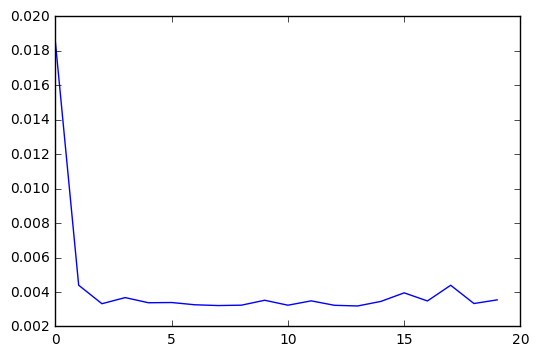

In [189]:
import matplotlib.pyplot as plt
%matplotlib inline

print(history.history.keys())

plt.plot(history.history['val_loss'])


### Testing

In [31]:
model = load_model('testmodel2')

In [32]:
slice_len = 2000

pos = 2

In [33]:
np.array(input_size)

array([  50, 2000,    8])

In [34]:
slice_start = i
slice_end = slice_start + slice_len
slice_x_raw = raw_data_test[:,slice_start:slice_end].T
f, t, slice_x = signal.spectrogram(slice_x_raw, fs=2000, nperseg=1000, noverlap=750, axis = 0, mode='angle')

In [35]:
slice_x.shape

(501, 4, 5)

In [36]:
len_test = raw_data_test.shape[1]
idxs = np.arange(0,len_test - slice_len,10)

txs_0 = np.zeros([idxs.shape[0],input_size[0],input_size[1],input_size[2]])
tys_0 = np.zeros([idxs.shape[0],1])

k = 0

for i in np.arange(0,len_test - slice_len,10):
    slice_start = i
    slice_end = slice_start + slice_len
    slice_x_raw = raw_data_test[:,slice_start:slice_end].T
    f, t, slice_x = signal.spectrogram(slice_x_raw, fs=2000, nperseg=1000, noverlap=750, axis = 0)
    slice_x = np.swapaxes(slice_x,1,2)
    slice_x = slice_x[:50,:,:]
    
    if pos==0:
        slice_y = mv_acc_test[0,slice_start]
    elif pos==1:
        slice_y = mv_acc_test[0,slice_mid]
    else:            
        slice_y = mv_acc_test[0,slice_end]
    
    txs_0[k] = slice_x
    tys_0[k] = slice_y
    
    k = k+1

ValueError: could not broadcast input array from shape (50,5,4) into shape (50,2000,8)

In [ ]:
tys_pred = model.predict(txs_0)

In [ ]:
plt.plot(tys_0,'r')
plt.plot(tys_pred,'g')
plt.show()

### Prepare test data (spec)

In [37]:
slice_len_spec

2000

In [38]:
slice_len = slice_len_spec
pos = 2

In [39]:
len_test = raw_data_test_spec.shape[1]
idxs = np.arange(0,len_test - slice_len,10)

txs_0 = np.zeros([idxs.shape[0],input_size[0],input_size[1],input_size[2]])
tys_0 = np.zeros([idxs.shape[0],1])

k = 0

for i in np.arange(0,len_test - slice_len,10):
    slice_start = i
    slice_end = slice_start + slice_len
    slice_x = raw_data_test_spec[:,slice_start:slice_end,:]
    
    if pos==0:
        slice_y = mv_acc_test[0,slice_start]
    elif pos==1:
        slice_y = mv_acc_test[0,slice_mid]
    else:            
        slice_y = mv_acc_test[0,slice_end]
    
    txs_0[k] = slice_x
    tys_0[k] = slice_y
    
    k = k+1

In [40]:
txs_0.shape

(3867, 50, 2000, 8)

In [41]:
tys_pred = model.predict(txs_0)

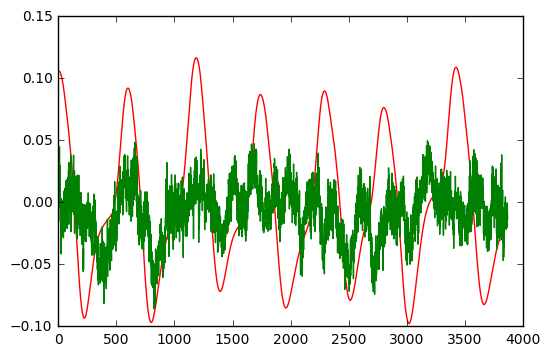

In [42]:
plt.plot(tys_0,'r')
plt.plot(tys_pred,'g')
plt.show()